In [2]:
# Essential Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from pathlib import Path  

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

# visualization
import matplotlib.pyplot as plt
import seaborn as sns 

# Algorithms
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from prophet import Prophet

# Model performance evaluation
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

#from minisom import MiniSom
#from tslearn.barycenters import dtw_barycenter_averaging
#from tslearn.clustering import TimeSeriesKMeans
#from sklearn.cluster import KMeans

In [99]:
def pullFilesbyPattern(pattern, filesNo):
    files = glob.glob(pattern)
    print(len(files))
    df = pd.DataFrame()
    fc =0
    for f in files:
        if fc >= filesNo:
            break    
        # Concat Instead of append
        df = pd.concat([df,pd.read_csv(f, low_memory=False)])
        fc += 1
        

    return df.reset_index(drop=True)
#ztedf = pullFilesbyPattern('..\ZTE_NBI\CallAccess_FDD_[0-9]*.csv', 50)
#ztedf.head()

In [13]:
def DataCleaning(df,firstMetricLoc):
    #isinstance(df[m], numbers.Number),
    df = df.copy()
    print(df.shape)
    
    metrics_list = df.columns.tolist()[firstMetricLoc:]
    metrics_list_error = []
    for m in metrics_list:
        # check if column is object and can be converted to float
        try:
            if df[m].dtype == 'object':
                df[m] = df[m].str.replace(',', '')
                df[m] = df[m].astype('float64')
        except ValueError:
            metrics_list_error.append(m)
            pass # skip columns that cannot be converted to float64
            
        # replace missing values with 0
        df[m] = df[m].fillna(0)
        
    return df, metrics_list_error


## the the datatime index and group the data by hour
def getDatasetbySites(df,date_col, site_name_column,granularity,firstMetricColumn):
    
    sites = df[site_name_column].unique()
    metrics_list = df.columns.tolist()[firstMetricColumn:]
   
    # Resultant list of datasets
    dset_list = []
    for site in sites:
        #print(site)
        dset = df.loc[df[site_name_column]==site].copy()
        #print(dset[site_name_column].unique())
        #df = df.drop_duplicates()
        dset['datetime'] = pd.to_datetime(dset[date_col])
        dset = dset.set_index('datetime')
    
        # Group data by hour using groupby() with pd.Grouper()
        dset = dset.groupby([pd.Grouper(freq=granularity, level='datetime')])[metrics_list].mean()
        #print(dset.dtypes)
        # Resample data by hour using resample()
        #dset = dset.resample(granularity).mean()
        
        # add the SiteCode column
        dset['SiteCode'] = site
        
        dset_list.append(dset)
    
    # Concatenate all datasets
    full_dataset = pd.concat(dset_list, axis=0)
    return full_dataset

def storeData(df, filename):
    filepath = Path(filename)  
    filepath.parent.mkdir(parents=True, exist_ok=True)  
    df.to_csv(filepath) 

def pullData(filename,date_col):
    filepath = Path(filename)
    df = pd.read_csv(filepath) 
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.set_index(date_col)
    return df

In [368]:
def remove_high_corr_features(df,threshold_in):
    # calculate the correlation matrix
    corr_matrix = df.corr()

    # select features with high correlation coefficients
    high_corr_features = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold_in:
                colname = corr_matrix.columns[i]
                high_corr_features.add(colname)
            
            
    # drop the highly correlated features from the dataset
    return df.drop(high_corr_features, axis=1)


def plot_corr_matrix(df):
    # calculate the correlation matrix
    corr_matrix = df.corr()

    # create a mask to ignore the diagonal elements of the correlation matrix
    mask = np.zeros_like(corr_matrix)
    mask[np.triu_indices_from(mask)] = True
    
    # plot the correlation matrix
    sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm')

# Normalized Values with StandardScaler or MinMaxScaler
# Use the VarianceThreshold feature_selection to remove all low-variance features.
def remove_low_variance_features(df,threshold_in):
    #print(.140 * (1 - .140))
    df  = df.copy()
    features = df.columns
    
    sel = VarianceThreshold(threshold=threshold_in) 
    x = sel.fit_transform(df)
    
    # Get the indices of the selected features
    selected_indices = sel.get_support(indices=True)
        
    # Get the names of the selected features
    selected_features = df.columns[selected_indices]
   
    #low_variance_features = intersection(features,selected_features)
    low_variance_features = set(features)-set(selected_features)
    
    #print('{} - {}'.format(len(features),len(selected_features)))
    #print(len(low_variance_features))
    
    # drop the highly correlated features from the dataset
    return df.drop(low_variance_features, axis=1)


def fillNa(df,rolling_window):
    df = df.copy()
   
    # Show the rows with NAN values
    nan_rows = df[df.isnull().any(axis=1)]
    
    while(nan_rows.shape[0] > 0):
        # Use transform to fill null values with the rolling mean of the corresponding group
        df = df.transform(lambda x: x.fillna(x.rolling(window=rolling_window, min_periods=1).mean()))
        nan_rows = df[df.isnull().any(axis=1)]
           
        # Fill null values with zeros
        #dset = dset.fillna(-999)
        # dset = dset.dropna()
    return df

def normalizedValues(df,scaler):
    df = df.copy()
    #scaler = StandardScaler()
    #scaler = MinMaxScaler((0, 1))
    # Min Max Scaler
    ts = scaler.fit_transform(df)

    lables = df.columns
    for i in range(len(lables)):
        df[lables[i]] = ts.T[i]
    
    return df

def rollingAvg(df,rolling_window):
    df = df.copy()
    df = df.rolling(window=rolling_window).mean()
    #df = df.transform(lambda x: x.fillna(x.rolling(window=rolling_window, min_periods=1).mean()))
    df = df.dropna()
    return df  

# Check for missing values
def getMissingValues(df):
    columns_missing_values = {}
    for c in df.columns:
        msv = df[df[c].isna()| df[c].eq(' ')].shape[0]
        if msv > 0:
            columns_missing_values[c] = (msv,msv/df.shape[0]*100)
    return columns_missing_values


In [6]:
clean_ds, invalid_columns = DataCleaning(ztedf,14)

(500820, 195)


In [391]:
clean_ds

NameError: name 'clean_ds' is not defined

In [17]:
dsbysite = pullData('..\AggregatedData\ZTE_CallAccess_FDD.csv','datetime')
dsbysite.head(5)

,Number of Successful Mt-Access RRC Establishment(times),Number of Mo-Data RRC Establishment Failure due to Timeout(times),Number of Mo-Signalling RRC Establishment Failure due to ENB Admission Failure(times),Number of Mo-Signalling RRC Establishment Failure due to Other Reason(times),Number of mo-VoiceCall RRC Establishment Failure due to Timeout(times),Number of mo-VoiceCall RRC Establishment Failure due to Other Reason(times),Number of mo-VoiceCall RRC Establishment Failure due to ENB Admission Failure(times),Number of Mt-Access RRC Establishment Failure due to Timeout(times),Number of Mo-Signalling RRC Establishment Failure due to Timeout(times),Number of Successful Mo-Signalling RRC Establishment(times),...,Number of Cell DRB Admission Failure due to PHY Resource Allocated Failure(times),Number of Cell Admission Failure due to Service Cell Other Parameters Modification(times),Number of Cell Admission Failure due to Target PLMN selected Failure(times),Number of Cell Admission Failure due to RRC Connection Number License Prohibit(times),Number of Cell Admission Failure due to E-RAB Number License Prohibit(times),Cell Service Time(s),Maximum Number of RRC Connection User(unit),Number of E-RAB HO Incoming Admission Request(unit),Number of E-RAB(QCI7) HO Incoming Admission Request(unit),SiteCode
datetime,,,,,,,,,,,,,,,,,,,,,
2023-01-31 00:00:00,0.0,0.041667,0.0,0.0,0.0,0.0,0.0,0.125,0.208333,0.0,...,0.0,0.0,0.0,0.0,0.0,900.0,6.083333,16.250000,1.916667,PAF003
2023-01-31 01:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.041667,0.0,...,0.0,0.0,0.0,0.0,0.0,900.0,5.041667,10.041667,1.583333,PAF003
2023-01-31 02:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.041667,0.0,...,0.0,0.0,0.0,0.0,0.0,900.0,5.000000,10.000000,1.958333,PAF003
2023-01-31 03:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.333333,0.0,...,0.0,0.0,0.0,0.0,0.0,900.0,4.458333,7.166667,1.458333,PAF003
2023-01-31 04:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.041667,0.0,...,0.0,0.0,0.0,0.0,0.0,900.0,4.500000,7.250000,1.666667,PAF003


In [7]:
dsbysite = getDatasetbySites(clean_ds,'Begin Time','eNodeB Name','H',14)
storeData(dsbysite,'..\AggregatedData\ZTE_CallAccess_FDD.csv')
#getMissingValues(dsbysite)

In [14]:
dsbysitetypes = pd.DataFrame(dsbysite.dtypes, columns=['dtypes'])
dsbysitetypes.index.name= 'Column'
storeData(dsbysitetypes,'..\AggregatedData\ZTE_CallAccess_FDD_dtypes.csv')

#### Site with Incidents with this period:
- PAF024	2023-01-03 03:13:00.0000000
- PAF024	2023-02-01 06:16:00.0000000
- LIM090	2023-02-05 17:53:00.0000000
- LIM003	2023-03-17 12:33:00.0000000
- PAF031	2023-03-29 08:37:00.0000000

In [18]:
#incidents = [('2023-01-03 03:13:00','PAF024',1),
#            ('2023-02-01 06:16:00','PAF024',1),
#            ('2023-02-05 17:53:00','LIM090',1),
#            ('2023-03-17 12:33:00','LIM003',1),
#            ('2023-03-29 08:37:00','PAF031',1)]
# Convert the list of tuples into a pandas dataframe
col = ['datetime', 'SiteCode','incident']
#df_incidents = pd.DataFrame(incidents, columns=col)

df_incidents = pd.read_csv('..\AggregatedData\RANSitesIncidents.csv')
df_incidents['datetime'] = pd.to_datetime(df_incidents['startdatetime'], format='%d/%m/%Y %H:%M:%S').dt.floor("H")
df_incidents['incident'] = 1
df_incidents = df_incidents[col]
df_incidents = df_incidents.drop_duplicates()

dsbysite = pd.merge(dsbysite, df_incidents, on=['datetime','SiteCode'], how='left')
dsbysite['incident'] = dsbysite['incident'].notnull()
dsbysite.set_index('datetime', inplace=True)
dsbysite.loc[dsbysite['incident']==True]

,Number of Successful Mt-Access RRC Establishment(times),Number of Mo-Data RRC Establishment Failure due to Timeout(times),Number of Mo-Signalling RRC Establishment Failure due to ENB Admission Failure(times),Number of Mo-Signalling RRC Establishment Failure due to Other Reason(times),Number of mo-VoiceCall RRC Establishment Failure due to Timeout(times),Number of mo-VoiceCall RRC Establishment Failure due to Other Reason(times),Number of mo-VoiceCall RRC Establishment Failure due to ENB Admission Failure(times),Number of Mt-Access RRC Establishment Failure due to Timeout(times),Number of Mo-Signalling RRC Establishment Failure due to Timeout(times),Number of Successful Mo-Signalling RRC Establishment(times),...,Number of Cell Admission Failure due to Service Cell Other Parameters Modification(times),Number of Cell Admission Failure due to Target PLMN selected Failure(times),Number of Cell Admission Failure due to RRC Connection Number License Prohibit(times),Number of Cell Admission Failure due to E-RAB Number License Prohibit(times),Cell Service Time(s),Maximum Number of RRC Connection User(unit),Number of E-RAB HO Incoming Admission Request(unit),Number of E-RAB(QCI7) HO Incoming Admission Request(unit),SiteCode,incident
datetime,,,,,,,,,,,,,,,,,,,,,
2023-02-01 06:00:00,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,203.958333,2.583333,3.875000,0.000000,PAF024,True
2023-03-17 12:00:00,0.0,0.166667,0.0,0.041667,0.0,0.0,0.0,0.0,0.208333,0.0,...,0.0,0.0,0.0,0.0,480.250000,17.375000,140.291667,2.208333,LIM003,True
2023-02-05 17:00:00,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,LIM090,True


## Filling Missing Values
#### Roaling Mean for 24 Hours

<Axes: xlabel='datetime'>

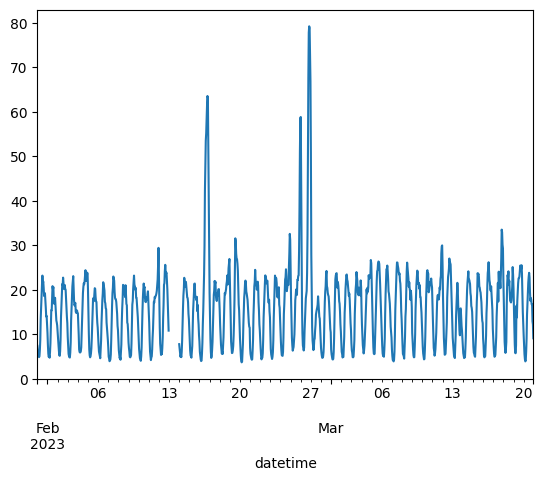

In [19]:
#### without Filling NA
site_df = dsbysite.loc[dsbysite['SiteCode'] == 'LIM003'].copy()
site_df = site_df.drop('SiteCode', axis=1)
#site_df[site_df.isnull().any(axis=1)].index
#.groupby([pd.Grouper(freq='D', level='datetime')]).mean()
site_df['Maximum Number of RRC Connection User(unit)'].plot()

0

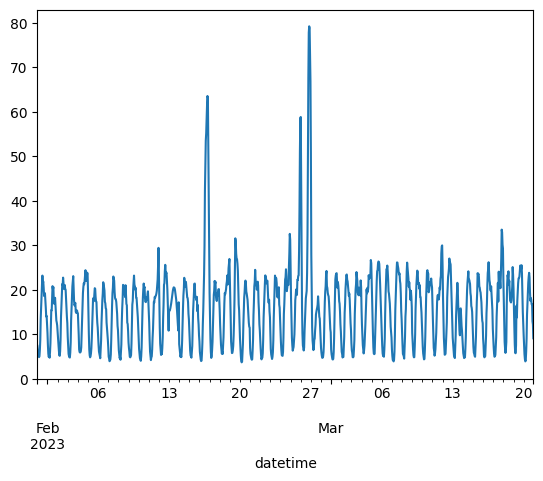

In [22]:
#### without Filling NA
site_df = dsbysite.loc[dsbysite['SiteCode'] == 'LIM003'].copy()
site_df = site_df.drop('SiteCode', axis=1)
site_df = fillNa(site_df,24)
#site_df = rollingAvg(site_df,24)

#site_df[site_df.isnull().any(axis=1)].index
#.groupby([pd.Grouper(freq='D', level='datetime')]).mean()
site_df['Maximum Number of RRC Connection User(unit)'].plot()

# Show the rows with NAN values
nan_rows = site_df[site_df.isnull().any(axis=1)]
nan_rows.shape[0]

## Data Observation
Apply features selections and observe the distribution of values

In [23]:
def plotMetrics(df, size_x, size_y):
    metrics = df.columns
    
    fig, axs = plt.subplots(size_y,size_x,figsize=(25,25))
    
    fig.suptitle('Series')
    for i in range(size_y):
        for j in range(size_x):
            if i*4+j+1>len(metrics): # pass the others that we can't fill
                continue
            axs[i, j].plot(df.index,df[metrics[i*4+j]]) #time_series_data[i*4+j].values)
            axs[i, j].set_title(metrics[i*4+j])
    plt.show()

#### VarianceThreshold 
is a simple baseline approach to feature selection. It removes all features whose variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e. features that have the same value in all samples.
As an example, suppose that we have a dataset with boolean features, and we want to remove all features that are either one or zero (on or off) in more than 80% of the samples. Boolean features are Bernoulli random variables, and the variance of such variables is given by

(1176, 64)
(1176, 8)


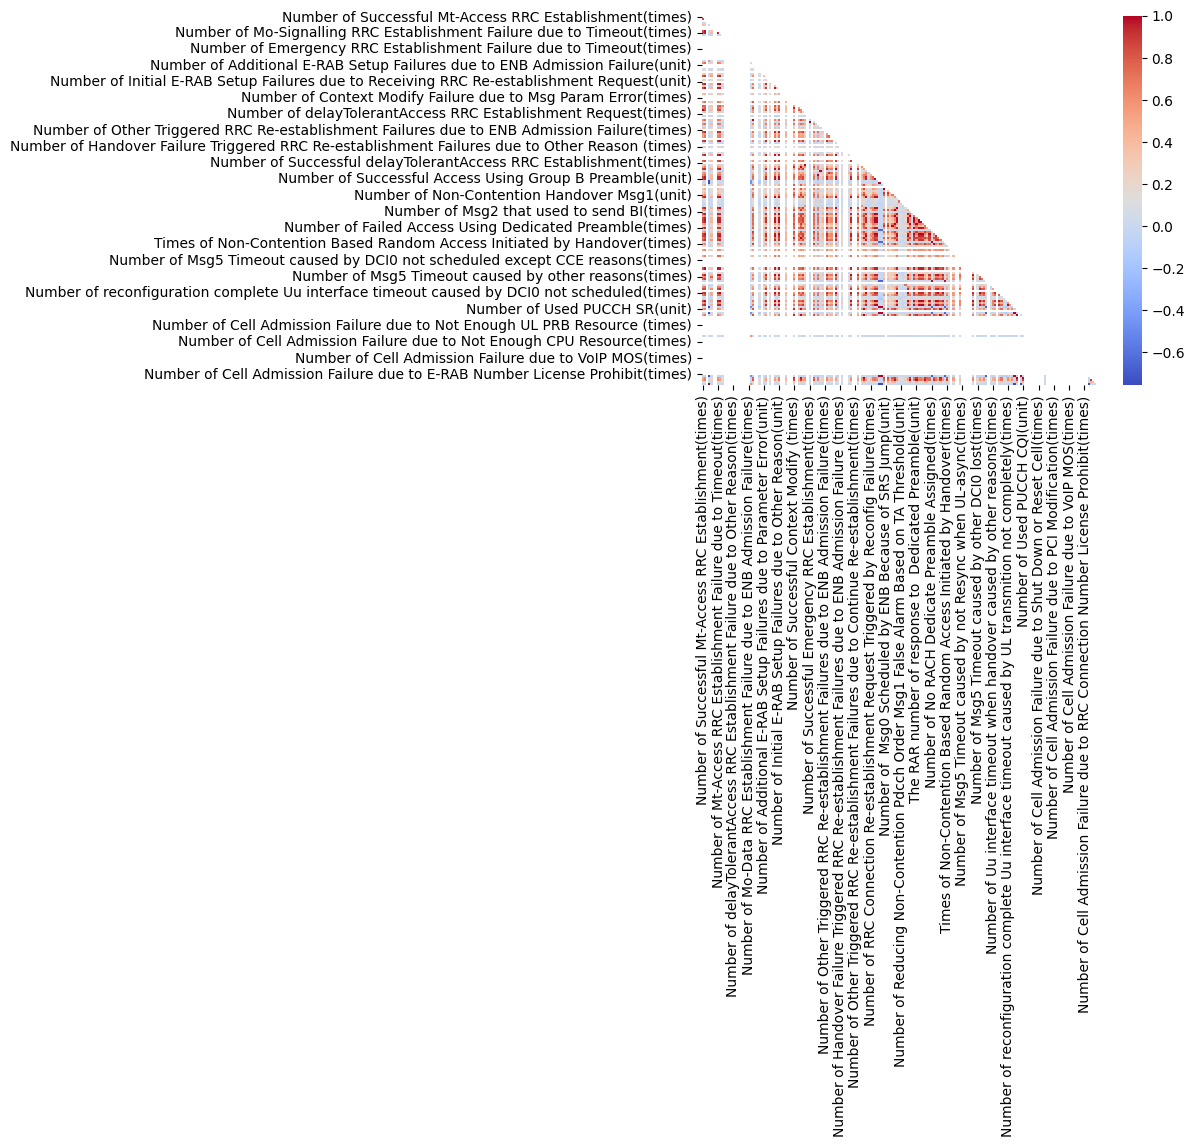

In [375]:
site_df = dsbysite.loc[dsbysite['SiteCode'] == 'LIM003'].copy()
site_df = site_df.drop('SiteCode', axis=1)
site_df = fillNa(site_df,24)

plot_corr_matrix(site_df)

site_df = remove_low_variance_features(site_df,0.05)
print(site_df.shape)
site_df = remove_high_corr_features(site_df,0.5)
print(site_df.shape)

site_df = normalizedValues(site_df,StandardScaler()) # MinMaxScaler((0, 1)) )
#getMissingValues(site_df)

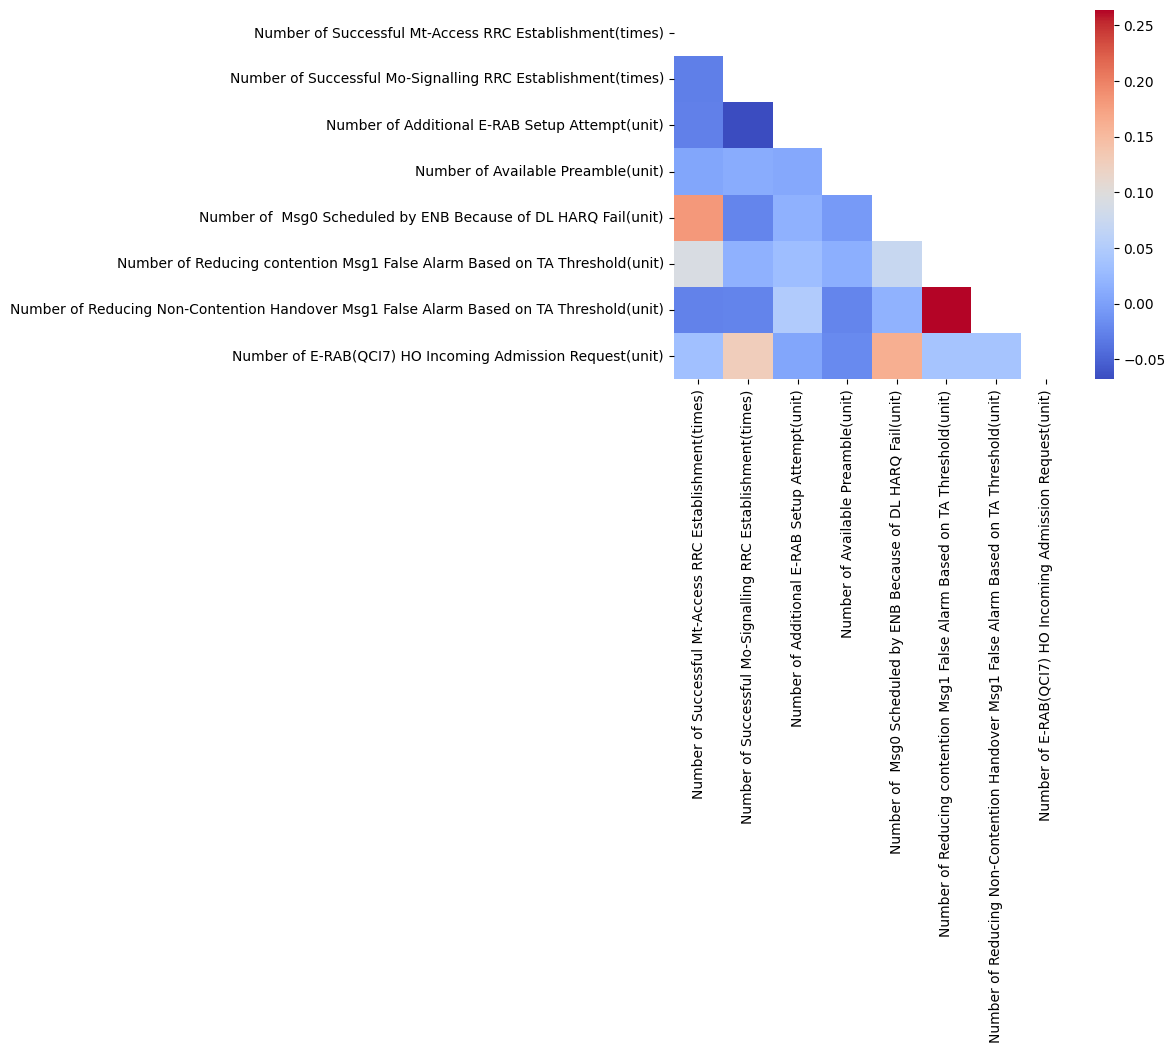

In [376]:
plot_corr_matrix(site_df)

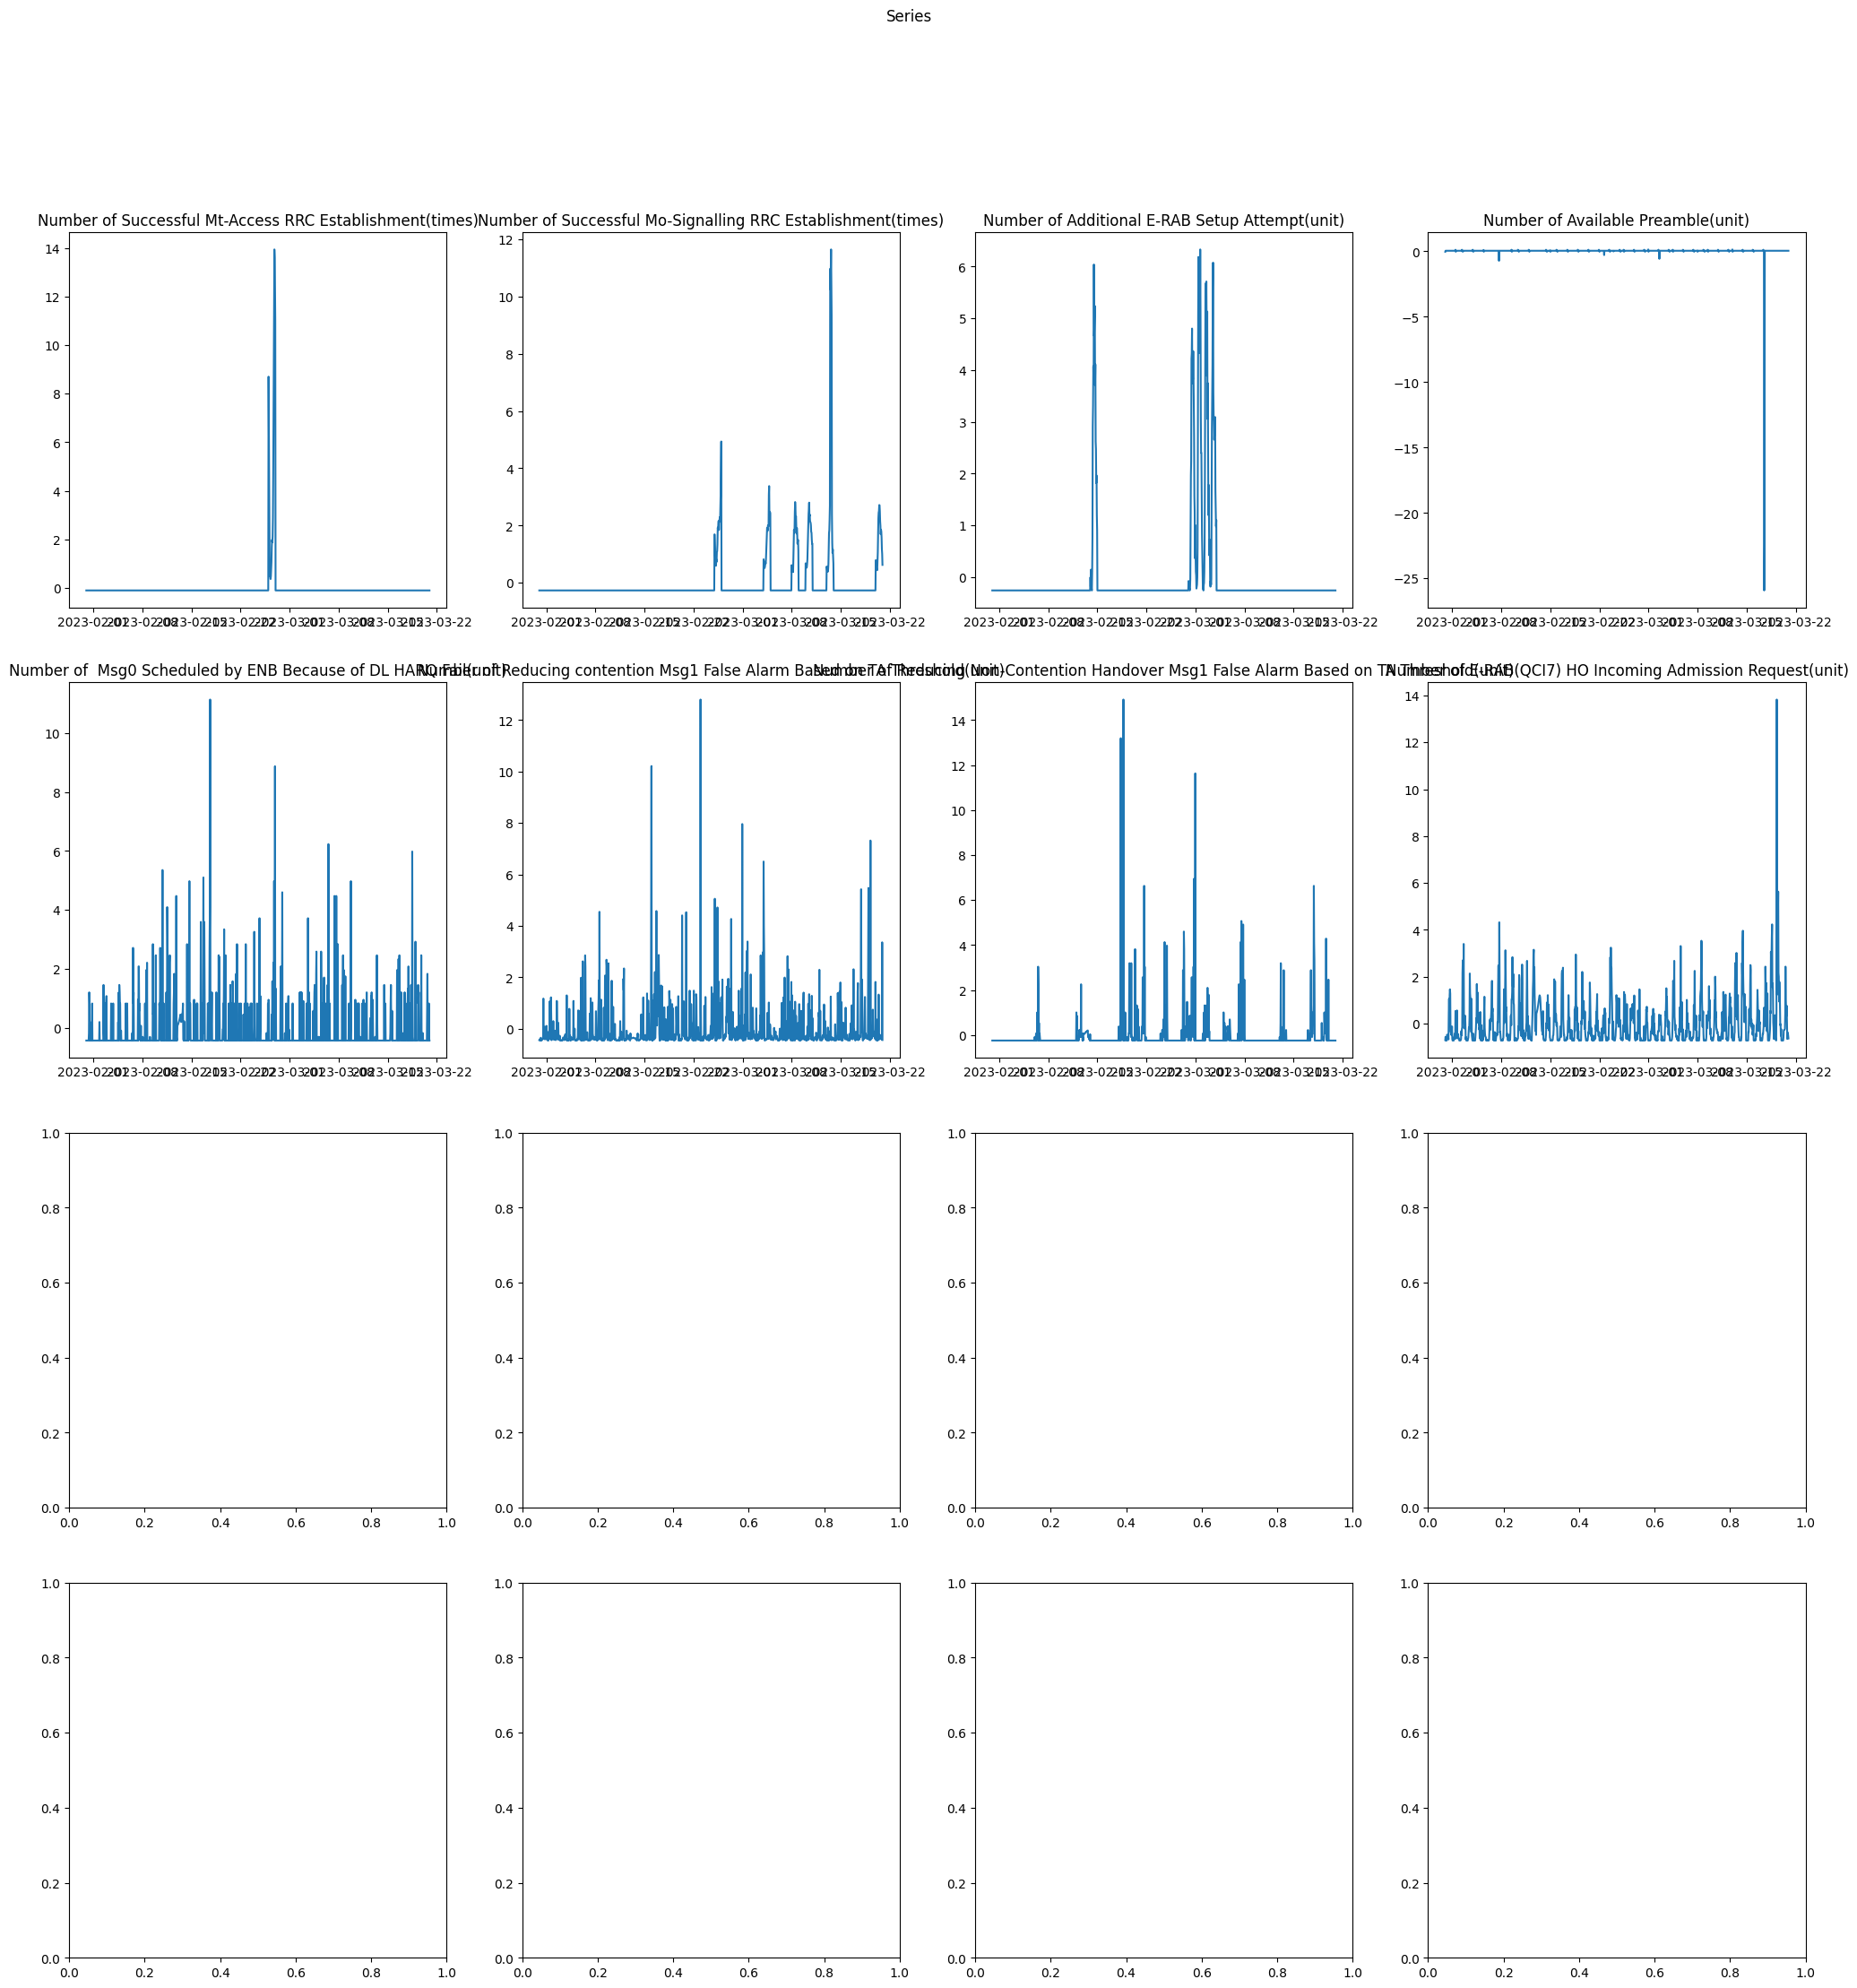

In [377]:
plotMetrics(site_df,4,4)

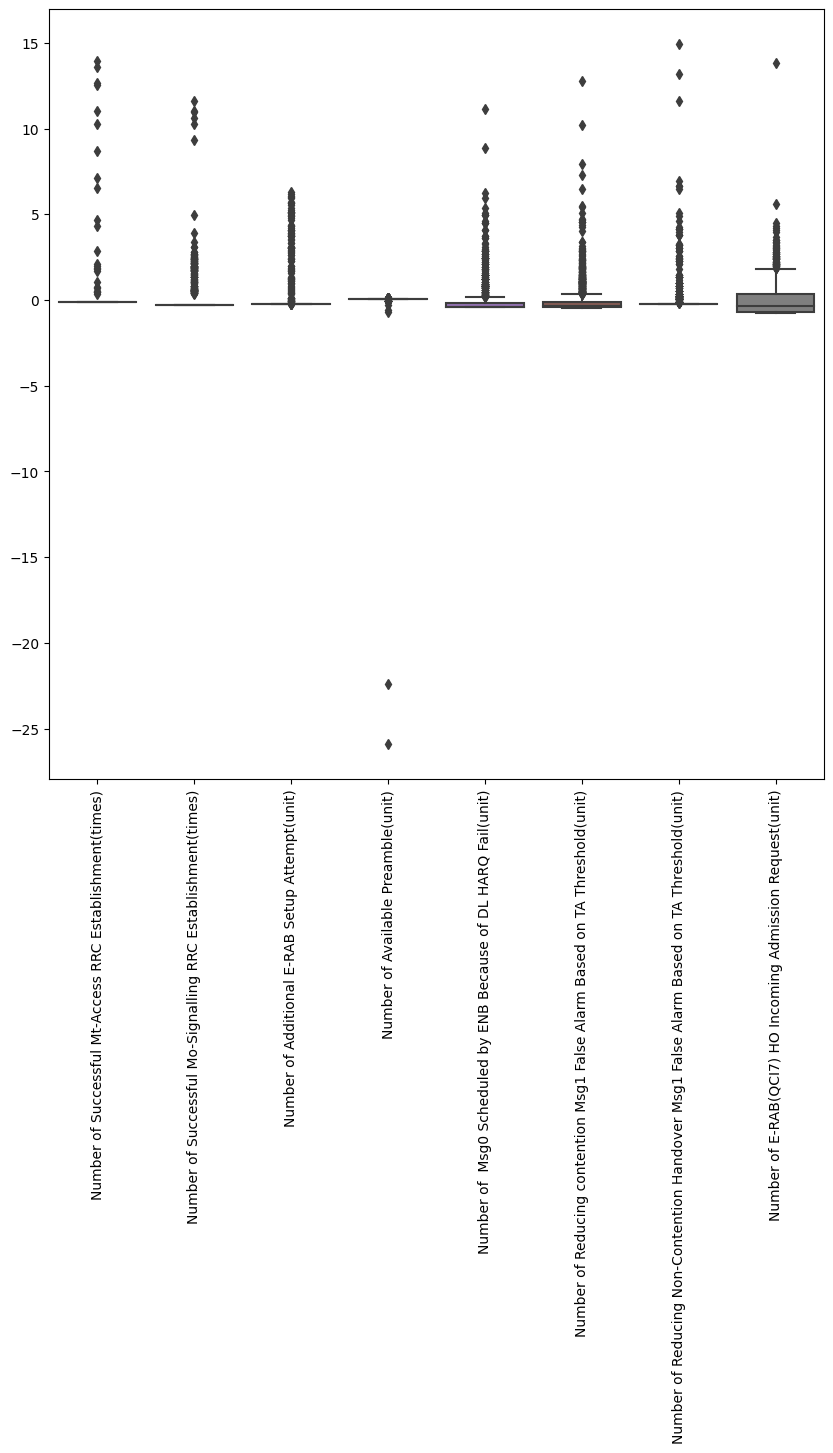

In [378]:
### Plot Outliers
import seaborn as sns # data visualization library  
plt.figure(figsize=(10,10))
sns.boxplot(data=site_df)
plt.xticks(rotation=90)
plt.show()

### Decompose Time-Series to See Components (Trend, Seasonality, Noise, etc)

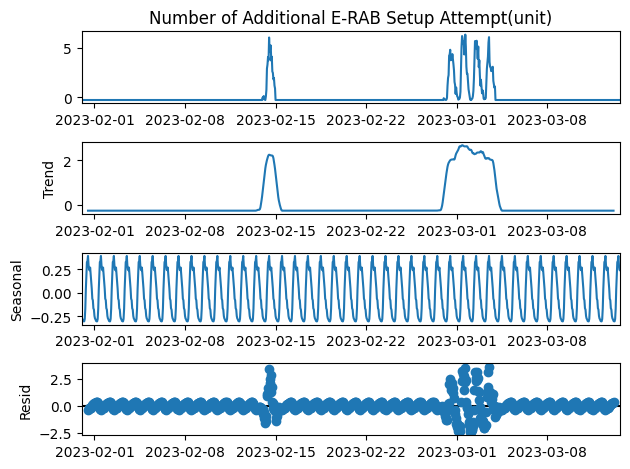

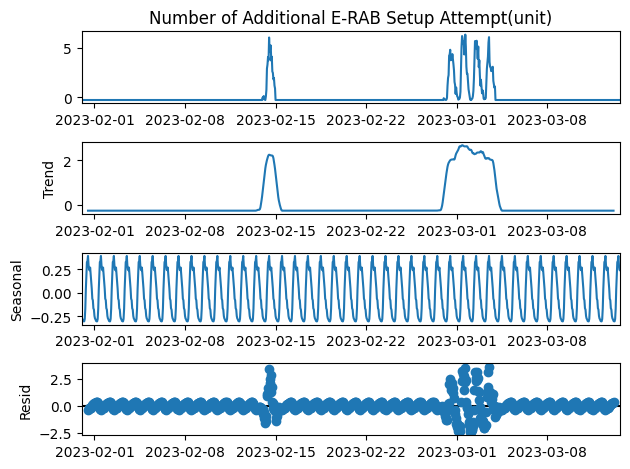

In [384]:
from statsmodels.tsa.seasonal import seasonal_decompose
df_plot = site_df[site_df.columns[2]][:1000]

sd = seasonal_decompose(df_plot, model='additive', period=24)
sd.plot()

In [385]:
#We investigate the possibility to get the running mean for a window of 30-60-90 days \
#in order to make the distribution of values more linear
#As you increase the windows the average become more and more linear
import plotly.graph_objects as go
col = site_df.columns[5]
print(col)
df_plt = site_df[col][1:1000].copy()
#df_plt = df_plt.set_index('datetime')
#df_plt.index =  pd.DatetimeIndex(df_plt.index)
#df_plt = df_plt[col].resample('H').mean()

DateMVA1 = df_plt.rolling(window=24).mean()
DateMVA2 = df_plt.rolling(window=168).mean()


fig = go.Figure()
fig.add_trace(go.Scatter(x=df_plt.index, y=df_plt.values,
                    mode='lines',
                    name='Amount per Day')
             )

fig.add_trace(go.Scatter(x=DateMVA1.index, y=DateMVA1.values,
                    mode='lines',
                    name='Moving Average for 24 Hours')
             )

fig.add_trace(go.Scatter(x=DateMVA2.index, y=DateMVA2.values,
                    mode='lines',
                    name='Moving Average for 168 Hours')
             )


fig.show()

Number of Reducing contention Msg1 False Alarm Based on TA Threshold(unit)


# Split the Data and Fit the Models

In [386]:
## the the datatime index and group the data by hour
def splitData(df, train_pct = 0.7):
    # get the unique dates from the index
    unique_days = pd.Series(df.index.date).unique()
    
    # calculate the number of rows for the training set
    train_size = int(len(unique_days) * train_pct)
    print(train_size)
        
    # calculate the end time of the training set
    train_end_time = df.index.min() + pd.Timedelta(train_size, unit="d")
    print(train_end_time)
    
    # separate the dataframe into training and testing sets
    train_df = df.loc[:train_end_time]
    test_df = df.loc[train_end_time + pd.Timedelta(hours=1):]
    
    return train_df,test_df
 
def fit_model(df,n_estimators, outliers_fraction):
        
    # Initialize the Isolation Forest algorithm 
    #n_estimators is the number of trees in the forest
    #contamination is the expected proportion of outliers in the data.
    #the percentage of outliers to be detected
    # warm_start=True, 
    model = IsolationForest(n_estimators=n_estimators, contamination=outliers_fraction)
    #(random_state=42) 
    
    #n_neighbors is the number of nearest neighbors used to calculate the local density
    #contamination is the expected proportion of outliers in the data
    #model = LocalOutlierFactor(n_neighbors=n_estimators, contamination=outliers_fraction, novelty=True)
    
    # iterate over the groups and process each window separately
    print('############# Train #############')
    # Fit the model to the data
    model.fit(df.values)

    return model

def predict(model,df):
    df= df.copy()
    # iterate over the groups and process each window separately
    print('############# Predict #############')

    # Predict the outliers using the trained model
    outliers = model.predict(df.values)
    X_scores = -model.decision_function(df.values)

    # Add the outlier predictions to the original data as a new column
    df['outliers'] = outliers
    df['scores'] = X_scores
    
    # compute the average path length (APL) for each instance in the data
    X_scores /= model.max_samples_
    X_scores = np.exp(X_scores.mean())
    print("Average path length (APL):", X_scores)
        
    return df


def fit_predict(df,n_estimators, outliers_fraction):
    df= df.copy()
    
    # Set the percentage of outliers to be detected
    estimators=n_estimators

    # Initialize the Isolation Forest algorithm 
    # warm_start=True, 
    #model = IsolationForest(n_estimators=estimators, contamination=outliers_fraction)
    # fit the model for outlier detection (default)
    model = LocalOutlierFactor(n_neighbors=n_estimators, contamination=outliers_fraction)
    
    # use fit_predict to compute the predicted labels of the training samples
    # (when LOF is used for outlier detection, the estimator has no predict,
    # decision_function and score_samples methods).
    outliers = model.fit_predict(df.values)
    #n_errors = (y_pred != ground_truth).sum()
    X_scores = model.negative_outlier_factor_
       
    df['outliers'] = outliers
    df['scores'] = X_scores

    return df 



(1176, 64)
(1176, 46)
Missing Values 0
30
2023-03-08 23:00:00
############# Train #############
############# Predict #############
Average path length (APL): 0.9994364876555188
2023-03-08 23:00:00


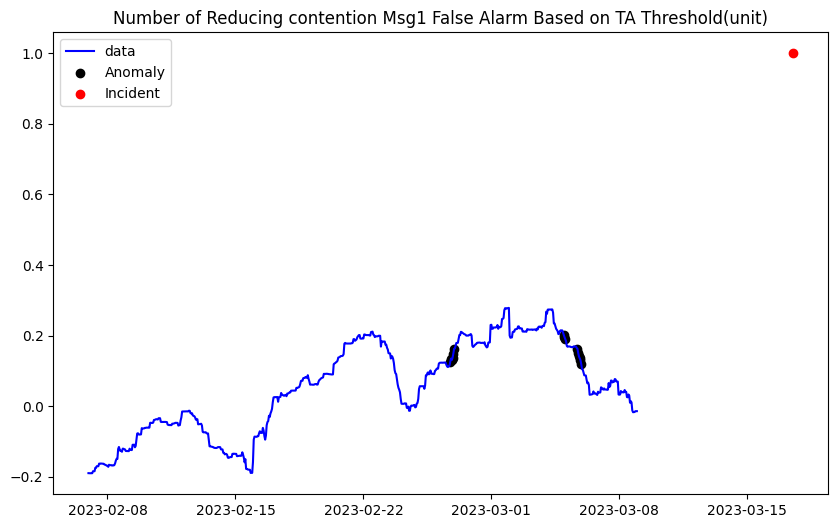

In [387]:
dfdata = dsbysite.loc[dsbysite['SiteCode'] == 'LIM003'].copy() #LIM090 LIM003 PAF024
dfdata = dfdata.drop('SiteCode', axis=1)
incident = dfdata['incident']
incident = incident.reset_index().set_index('datetime')
dfdata = dfdata.drop('incident', axis=1)

dfdata = fillNa(dfdata,6)

dfdata = remove_low_variance_features(dfdata,0.05)
print(dfdata.shape)
dfdata = remove_high_corr_features(dfdata,0.999)
print(dfdata.shape)

dfdata = normalizedValues(dfdata,StandardScaler()) # MinMaxScaler((0, 1)) )
dfdata = rollingAvg(dfdata,168)

print('Missing Values {}'.format(len(getMissingValues(dfdata))))

train_data,test_data = splitData(dfdata,0.7)


#########################################################
model = fit_model(train_data,20, 0.02)
#print(model.estimator_)
data = predict(model,train_data)
print(max(data.index))

#col = data.columns[8]
#col = 'Maximum Number of RRC Connection User(unit)'

outliers = data.loc[data['outliers'] == -1, col] #anomaly
incident = incident.loc[incident['incident'] == True]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(data.index, data[col], color='blue', label = 'data')
ax.scatter(outliers.index,outliers, color='black', label = 'Anomaly')
ax.scatter(incident.index,incident, color='red', label = 'Incident')
plt.title(col)
plt.legend()
plt.show();

############# Predict #############
Average path length (APL): 0.9995986497906303
2023-03-09 00:00:00


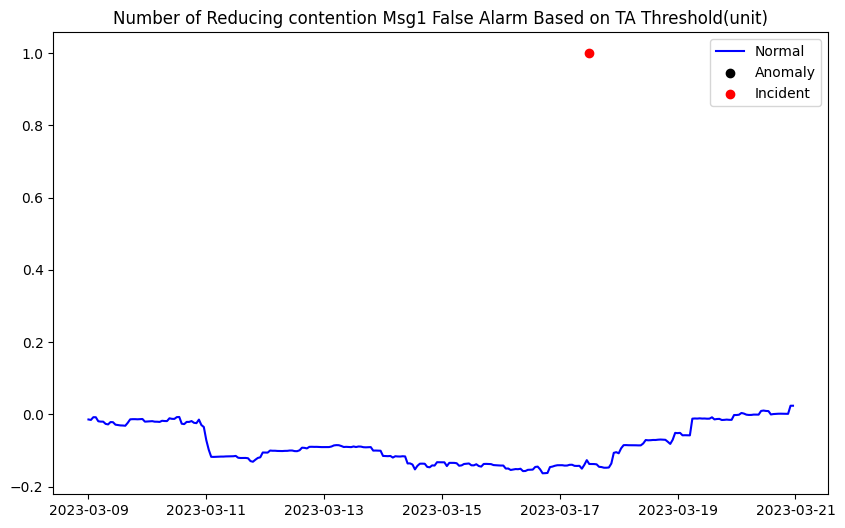

,Number of Successful Mt-Access RRC Establishment(times),Number of Mo-Data RRC Establishment Failure due to Timeout(times),Number of Mt-Access RRC Establishment Failure due to Timeout(times),Number of Mo-Signalling RRC Establishment Failure due to Timeout(times),Number of Successful Mo-Signalling RRC Establishment(times),Number of Successful Mo-Data RRC Establishment(times),Number of Initial E-RAB Setup Failures due to Uu interface Failure(unit),Number of Initial E-RAB Setup Failures due to Other Reason(unit),Number of Successful Context Modify (times),Number of Mo-Signalling RRC Establishment Request(times),...,Number of Successful Msg4 Checked by ENB(times),Number of Failure Msg4 Checked by ENB(times),Times of Non-Contention Based Random Access Initiated by Handover(times),Number of reconfiguration complete Uu interface timeout caused by UL transmition not completely(times),Number of Used PUCCH SR(unit),Maximum Number of RRC Connection User(unit),Number of E-RAB HO Incoming Admission Request(unit),Number of E-RAB(QCI7) HO Incoming Admission Request(unit),outliers,scores
datetime,,,,,,,,,,,,,,,,,,,,,


In [388]:
#########################################################
data = predict(model,test_data)
print(min(data.index))

outliers = data.loc[data['outliers'] == -1, col] #anomaly
incident = incident.loc[incident['incident'] == True]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(data.index, data[col], color='blue', label = 'Normal')
ax.scatter(outliers.index,outliers, color='black', label = 'Anomaly')
ax.scatter(incident.index,incident, color='red', label = 'Incident')
plt.title(col)
plt.legend()
plt.show();
a.index
# Filter the original data to only include the non-outliers
outliers = data.loc[data['outliers'] == -1]
outliers.sort_values('scores').head(5)

In [327]:
#data = predict(model,test_groups)
# Filter the original data to only include the non-outliers
#outliers = data[data['outliers'] == -1]
#outliers

# Filter the original data to only include the non-outliers
#outliers = data[data['outliers'] == -1]
#outliers

,incident
datetime,
2023-03-17 12:00:00,True


### Tuning Hyperparameter
#### IsolationForest

In [366]:
df = data.copy()
y = df['outliers'].values
df = df.drop('outliers', axis=1).copy()
df = df.drop('scores', axis=1)
x = df.values
print(x.shape)
print(y.shape)

(721, 46)
(721,)


In [389]:
dfdata = dsbysite.loc[dsbysite['SiteCode'] == 'LIM003'].copy()
dfdata = dfdata.drop('SiteCode', axis=1)
dfdata_label = dfdata['incident']
dfdata_label = dfdata_label.reset_index().fillna(False)
dfdata = dfdata.drop('incident', axis=1)
dfdata = fillNa(dfdata,24)

dfdata = remove_low_variance_features(dfdata,0.05)
print(dfdata.shape)
dfdata = remove_high_corr_features(dfdata,0.99)
print(dfdata.shape)

dfdata = normalizedValues(dfdata,StandardScaler()) # MinMaxScaler((0, 1)) )

x = dfdata.values
y = dfdata_label['incident'].values

(1176, 64)
(1176, 37)


In [312]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import make_scorer, mean_squared_error

# create an instance of the LocalOutlierFactor class
model = IsolationForest() 

# define the parameter grid for hyperparameter tuning
param_grid = {'n_estimators': [5, 10, 20,30]
              , 'contamination': [0.02,0.05, 0.1, 0.15]}

# define a custom scorer function
def custom_scorer(model, X, y_true):
    y_pred = -model.decision_function(X)
    return mean_squared_error(y_true, y_pred)

custom_scorer = make_scorer(custom_scorer, greater_is_better=False, needs_proba=False, needs_threshold=False)

# create a GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2')

#
#neg_mean_squared_error
#"neg_median_absolute_error",
#"r2",
#"neg_mean_absolute_error",
#"neg_mean_absolute_percentage_error",
#"neg_mean_squared_log_error", neg_mean_squared_error
#"neg_root_mean_squared_error",

# fit the GridSearchCV object to the data
grid_search.fit(x,y)

# print the best hyperparameters and the corresponding score
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best hyperparameters: {'contamination': 0.02, 'n_estimators': 5}
Best score: -0.7092670645190713


In [303]:
print(train_data.shape)
print(test_data.shape)

(817, 46)
(359, 46)


### Tuning Hyperparameter
#### LocalOutlierFactor

In [390]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import make_scorer, mean_squared_error

dfdata = dsbysite.loc[dsbysite['SiteCode'] == 'LIM003'].copy()
dfdata = dfdata.drop('SiteCode', axis=1)
dfdata_label = dfdata['incident']
dfdata_label = dfdata_label.reset_index().fillna(False)
dfdata = dfdata.drop('incident', axis=1)
dfdata = fillNa(dfdata,24)

dfdata = remove_low_variance_features(dfdata,0.05)
print(dfdata.shape)
dfdata = remove_high_corr_features(dfdata,0.99)
print(dfdata.shape)

dfdata = normalizedValues(dfdata,StandardScaler()) # MinMaxScaler((0, 1)) )

x = dfdata.values
y = dfdata_label['incident'].values

#dfdata = rollingAvg(dfdata,24)
#print('Missing Values {}'.format(len(getMissingValues(dfdata))))
#print('Missing Values {}'.format(len(getMissingValues(dfdata_label))))

##############################################################

# create an instance of the LocalOutlierFactor class
model = LocalOutlierFactor() 

# define the parameter grid for hyperparameter tuning
param_grid = {'n_neighbors': [5, 10, 20, 30], 
              'contamination': [0.02,0.05, 0.1, 0.15],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'novelty' : [True]}


# define a custom scorer function
def custom_scorer(model, X, y_true):
    y_pred = -model.decision_function(X)
    return mean_squared_error(y_true, y_pred)

custom_scorer = make_scorer(custom_scorer, greater_is_better=False, needs_proba=False, needs_threshold=False)

# create a GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2')

# fit the GridSearchCV object to the data
grid_search.fit(x, y)

#
#neg_mean_squared_error
#"neg_median_absolute_error",
#"r2",
#"neg_mean_absolute_error",
#"neg_mean_absolute_percentage_error",
#"neg_mean_squared_log_error", neg_mean_squared_error
#"neg_root_mean_squared_error",


# print the best hyperparameters and the corresponding score
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

(1176, 64)
(1176, 37)
Best hyperparameters: {'algorithm': 'auto', 'contamination': 0.02, 'n_neighbors': 5, 'novelty': True}
Best score: -47.603418803418826


### TimeSeriesSplit 

In [402]:
dfdata

,Number of Successful Mt-Access RRC Establishment(times),Number of Mo-Data RRC Establishment Failure due to Timeout(times),Number of Mo-Signalling RRC Establishment Failure due to ENB Admission Failure(times),Number of Mo-Signalling RRC Establishment Failure due to Other Reason(times),Number of mo-VoiceCall RRC Establishment Failure due to Timeout(times),Number of mo-VoiceCall RRC Establishment Failure due to Other Reason(times),Number of mo-VoiceCall RRC Establishment Failure due to ENB Admission Failure(times),Number of Mt-Access RRC Establishment Failure due to Timeout(times),Number of Mo-Signalling RRC Establishment Failure due to Timeout(times),Number of Successful Mo-Signalling RRC Establishment(times),...,Number of Cell DRB Admission Failure due to Not Enough CPU Resource(times),Number of Cell DRB Admission Failure due to PHY Resource Allocated Failure(times),Number of Cell Admission Failure due to Service Cell Other Parameters Modification(times),Number of Cell Admission Failure due to Target PLMN selected Failure(times),Number of Cell Admission Failure due to RRC Connection Number License Prohibit(times),Number of Cell Admission Failure due to E-RAB Number License Prohibit(times),Cell Service Time(s),Maximum Number of RRC Connection User(unit),Number of E-RAB HO Incoming Admission Request(unit),Number of E-RAB(QCI7) HO Incoming Admission Request(unit)
datetime,,,,,,,,,,,,,,,,,,,,,
2023-01-31 00:00:00,0.0,0.041667,0.0,0.0,0.0,0.0,0.0,0.000000,0.041667,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,900.0,7.416667,42.041667,0.041667
2023-01-31 01:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,900.0,6.500000,21.291667,0.291667
2023-01-31 02:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,900.0,5.583333,12.250000,0.000000
2023-01-31 03:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,900.0,5.291667,6.958333,0.000000
2023-01-31 04:00:00,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.000000,0.041667,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,900.0,4.875000,5.500000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-20 19:00:00,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.041667,0.166667,25.416667,...,0.0,0.0,0.0,0.0,0.0,0.0,900.0,16.750000,226.250000,0.125000
2023-03-20 20:00:00,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.000000,0.083333,22.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,900.0,16.750000,180.041667,0.583333
2023-03-20 21:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.083333,0.166667,17.791667,...,0.0,0.0,0.0,0.0,0.0,0.0,900.0,12.916667,136.708333,0.625000


In [423]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
import numpy as np

dfdata = dsbysite.loc[dsbysite['SiteCode'] == 'LIM003'].copy()
dfdata = dfdata.drop('SiteCode', axis=1)
dfdata_label = dfdata['incident']
dfdata_label = dfdata_label.reset_index().fillna(False)
dfdata = dfdata.drop('incident', axis=1)
dfdata = fillNa(dfdata,24)
dfdata

# create an instance of the IsolationForest class
model = IsolationForest()

# define the time-series cross-validation iterator
cv = TimeSeriesSplit(n_splits=24)

# iterate over the folds and compute the F1 score for each fold
scores = []
for i, (train_idx, test_idx) in enumerate(cv.split(dfdata)):
    print(f"++++++++++++++++++ Fold {i}: ++++++++++++++++++++++++")
    print(f"  Train: index={train_idx}")
    print(f"  Test:  index={test_idx}")
    # split the data into training and test sets
    X_train, X_test = dfdata.iloc[train_idx], dfdata.iloc[test_idx]


    # fit the model to the training data
    #model.fit(X_train)

    # predict the labels for the test data
    #y_pred = model.predict(X_test)

    # compute the F1 score for the test data
    #score = f1_score(np.ones(len(y_pred)), y_pred, pos_label=-1)
    #scores.append(score)
    
# compute the mean F1 score across the folds
#mean_score = np.mean(scores)

#print("Mean F1 Score:", mean_score)

++++++++++++++++++ Fold 0: ++++++++++++++++++++++++
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
  Test:  index=[48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94]
++++++++++++++++++ Fold 1: ++++++++++++++++++++++++
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94]
  Test:  index=[ 95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141]
++++++++++++++++++ Fold 2: ++++++++++++++++++++++++
  Train: in

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
import numpy as np

# load the time-series data
data = np.loadtxt("time_series_data.csv", delimiter=",")

# create an instance of the IsolationForest class
model = IsolationForest()

# define the time-series cross-validation iterator
cv = TimeSeriesSplit(n_splits=5)

# iterate over the folds and compute the F1 score for each fold
scores = []
for train_idx, test_idx in cv.split(data):
    # split the data into training and test sets
    X_train, X_test = data[train_idx], data[test_idx]

    # fit the model to the training data
    model.fit(X_train)

    # predict the labels for the test data
    y_pred = model.predict(X_test)

    # compute the F1 score for the test data
    score = f1_score(np.ones(len(y_pred)), y_pred, pos_label=-1)
    scores.append(score)

# compute the mean F1 score across the folds
mean_score = np.mean(scores)

print("Mean F1 Score:", mean_score)